# Figure show label distributions

Figure to generate the figure showing labels and their distributions

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import pandas as pd
import numpy as np
import pink_utils as pu
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')
df.shape

(7464, 78)

In [3]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')

In [4]:
from collections import defaultdict

def ed_to_pb(ed):
    ed = ed - np.min(ed)
    ed = 1. / (1.+ed)
    ed = ed / np.sum(ed)
    
    return ed

def make_counts(df, hm, realisations=1):
    book = defaultdict(list)
    global_counts = defaultdict(int)
    
    for index, row in df.iterrows():
        if realisations == 1:
            heat = hm.ed(index=index)
            item = row['label'].replace('_','\_')
            item = f'{item}'
            loc = np.unravel_index(np.argmin(heat, axis=None), heat.shape)
            book[loc].append(item)
            global_counts[loc] += 1
        else:
            prob = hm.ed(index=index, prob=True)
#             prob = ed_to_pb(hm.ed(index=index, prob=False))
            item = row['label'].replace('_','\_')
            item = f'{item}'
#             print(item)

            pixels = range(np.prod(prob.shape))
            
            rand_pos = np.random.choice(pixels, size=realisations, p=prob.flatten())
            xd = rand_pos // prob.shape[0]
            yd = rand_pos % prob.shape[1]            
            locs = [(x,y) for x,y in zip(xd, yd)]
            for loc in locs:
                book[loc].append(item)
                # This is dangerous. Item HAS to be a list. Be aware that this could
                # be a problem later
#                 print(item)
                global_counts[item] += 1
        
    return book, global_counts

book, counts = make_counts(df, hm, realisations=100)

In [5]:
counts

defaultdict(int,
            {'1\\_1': 194700,
             '1\\_2': 178600,
             '1\\_3': 77500,
             '2\\_2': 158500,
             '2\\_3': 63100,
             '3\\_3': 74000})

In [6]:
def get_shape(book):
    max_shape = 0

    for i in book.keys():
        curr_shape = i[0]*i[1]
        if curr_shape > max_shape:
            max_shape = curr_shape
            shape = i

    return shape

def label_plot(book, shape, save=None, xtick_rotation=None, 
                color_map='gnuplot2', title=None, weights=None, figsize=(6,6),
                literal_path=False, count_text=False):
    '''Isolated function to plot the attribute histogram if the data is labelled in 
    nature

    book - dict
        A dictionary whose keys are the location on the heatmap, and values
        are the list of values of sources who most belonged to that grid
    shape - tuple
        The shape of the grid. Should attempt to get this from the keys or
        possible recreate it like in self.attribute_heatmap() 
    save - None or Str
        If None, show the figure on screen. Otherwise save to the path in save
    xtick_rotation - None or float
        Will rotate the xlabel by rotation
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()
    title - None of str
        A simple title strng passed to fig.suptitle()
    weights - None or dict
        If not None, the dict will have keys corresponding to the labels, and contain the total
        set of counts from the Binary file/book object. This will be used to `weigh` the contribution
        per neuron, to instead be a fraction of dataset type of statistic. 
    figsize - tuple of int
        Size of the figure to produce. Passed directly to plt.subplots
    literal_path - bool
        If true, take the path and do not modify it. If False, prepend the project_dir path
    count_label - bool
        If true, put as an anotation the counts of items in that neuron plot
    '''
    # Need access to the Normalise and ColorbarBase objects
    import matplotlib as mpl
    # Step one, get unique items and their counts
    from collections import Counter
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    unique_labels = []
    for k, v in book.items():
#         v = [i for items in v for i in items]    
        unique_labels += v
        
    unique_labels = list(set(unique_labels))
    unique_labels.sort()
    
    max_val = 0
    plt_book = {}
    
    for k, v in book.items():
#         v = [i for items in v for i in items]
        c = Counter(v)

        # Guard agaisnt empty most similar neuron
        if len(v) > 0:
            if weights is not None:
                plt_book[k] = { label: c[label] / weights[label] for label in unique_labels }
            else:
                plt_book[k] = { label: c[label] / len(v) for label in unique_labels }
                
            mv = max(plt_book[k].values())
            max_val = mv if mv > max_val else max_val
        else:
            plt_book[k] = None

    if weights is not None:
        cb_label = 'Fraction of Dataset'
        norm = mpl.colors.Normalize(vmin=0, vmax=max_val)
    else:
        cb_label = 'Fraction per Neuron'
        norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap = plt.get_cmap(color_map)
    fig, ax = plt.subplots(nrows=shape[0]+1, ncols=shape[1]+1, figsize=figsize)

    # Set empty axis labels for everything
    for a in ax.flatten():
        a.set(xticklabels=[], yticklabels=[])

    for k, v in plt_book.items():
        if v is None:
            continue

        color = cmap(norm(list(v.values())))

        ax[k].bar(np.arange(len(unique_labels)),
                 [1]*len(unique_labels),
                 color=color,
                 align='center',
                 tick_label=unique_labels)

        ax[k].set(ylim=[0,1])

        if k[1] != -1: # disable this for now.
            ax[k].set(yticklabels=[])
        if k[0] != shape[1]:
            ax[k].set(xticklabels=[])
        else:
            if xtick_rotation is not None:
                ax[k].tick_params(axis='x', rotation=xtick_rotation)
                for item in ax[k].get_xticklabels():
                    item.set_fontsize(7.5)
        
        if k[0] == 0:
            ax[k].set(title=k[1])
        
        if k[1] == 0:
            ax[k].set_ylabel(letters[k[0]], rotation=0, va='center')
            
        if count_text:
#             v = [i for items in book[k] for i in items]
            v = book[k]
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
            if isinstance(count_text, tuple):
                ax[k].annotate(f'{len(v)}', xy=count_text, xycoords='axes fraction', bbox=bbox_props)
            else:
                ax[k].annotate(f'{len(v)}', xy=(0.1,0.65), xycoords='axes fraction', bbox=bbox_props)
                
        
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.84, 0.10, 0.03, 0.8])
     
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label=cb_label)

    if save is None:
        plt.show()
    else:
        plt.savefig(save)

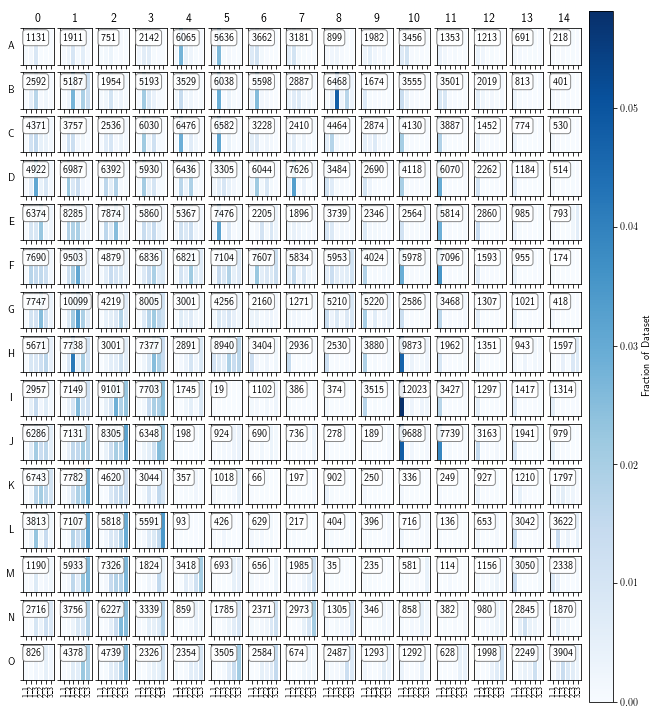

In [7]:
label_plot(book, get_shape(book), color_map='Blues', figsize=(11,12), xtick_rotation=90, count_text=True, weights=counts)

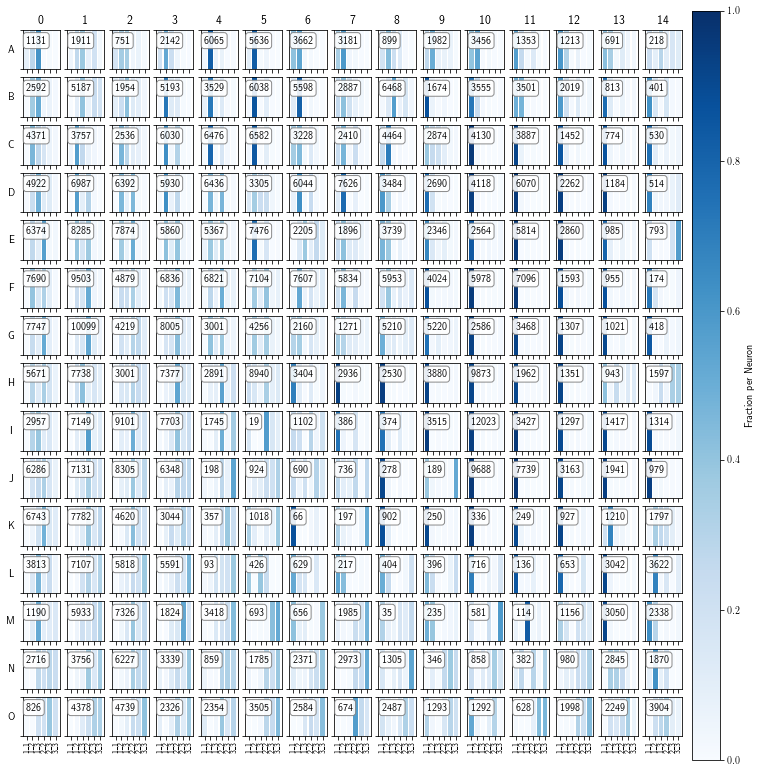

In [8]:
label_plot(book, get_shape(book), color_map='Blues', figsize=(13,13), xtick_rotation=90, count_text=True,
           save='Images/Figure_Label_Distribution.pdf')#, weights=counts)

In [9]:

def label_plot_heat(book, shape, save=None, xtick_rotation=None, 
                color_map='gnuplot2', title=None, weights=None, figsize=(6,6),
                literal_path=False, count_text=False):
    '''Isolated function to plot the attribute histogram if the data is labelled in 
    nature

    book - dict
        A dictionary whose keys are the location on the heatmap, and values
        are the list of values of sources who most belonged to that grid
    shape - tuple
        The shape of the grid. Should attempt to get this from the keys or
        possible recreate it like in self.attribute_heatmap() 
    save - None or Str
        If None, show the figure on screen. Otherwise save to the path in save
    xtick_rotation - None or float
        Will rotate the xlabel by rotation
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()
    title - None of str
        A simple title strng passed to fig.suptitle()
    weights - None or dict
        If not None, the dict will have keys corresponding to the labels, and contain the total
        set of counts from the Binary file/book object. This will be used to `weigh` the contribution
        per neuron, to instead be a fraction of dataset type of statistic. 
    figsize - tuple of int
        Size of the figure to produce. Passed directly to plt.subplots
    literal_path - bool
        If true, take the path and do not modify it. If False, prepend the project_dir path
    count_label - bool
        If true, put as an anotation the counts of items in that neuron plot
    '''
    # Need access to the Normalise and ColorbarBase objects
    import matplotlib as mpl
    # Step one, get unique items and their counts
    from collections import Counter
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    unique_labels = []
    for k, v in book.items():
#         v = [i for items in v for i in items]    
        unique_labels += v
        
    unique_labels = list(set(unique_labels))
    unique_labels.sort()
    
    max_val = 0
    plt_book = {}
    
    min_length = 1e10
    max_length = 0
    for k, v in book.items():
#         v = [i for items in v for i in items]
        c = Counter(v)

        if len(v) < min_length:
            min_length = len(v)
        elif len(v) > max_length:
            max_length = len(v)
    
        # Guard agaisnt empty most similar neuron
        if len(v) > 0:
            if weights is not None:
                plt_book[k] = { label: c[label] / weights[label] for label in unique_labels }
            else:
                plt_book[k] = { label: c[label] / len(v) for label in unique_labels }
                
            mv = max(plt_book[k].values())
            max_val = mv if mv > max_val else max_val
        else:
            plt_book[k] = None

    if weights is not None:
        cb_label = 'Fraction of Dataset'
        norm = mpl.colors.Normalize(vmin=0, vmax=max_val)
    else:
        cb_label = 'Fraction per Neuron'
        norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap = plt.get_cmap(color_map)
    
    heat_norm = mpl.colors.Normalize(vmin=min_length, vmax= max_length*1.5)
    heat_cmap = plt.get_cmap('YlOrRd')
    
    fig, ax = plt.subplots(nrows=shape[0]+1, ncols=shape[1]+1, figsize=figsize)

    # Set empty axis labels for everything
    for a in ax.flatten():
        a.set(xticklabels=[], yticklabels=[])

    for k, v in plt_book.items():
        if v is None:
            continue

        color = cmap(norm(list(v.values())))

        ax[k].bar(np.arange(len(unique_labels)),
                 [1]*len(unique_labels),
                 color=color,
                 align='center',
                 tick_label=unique_labels)

        ax[k].set(ylim=[0,1])

        if k[1] != -1: # disable this for now.
            ax[k].set(yticklabels=[])
        if k[0] != shape[1]:
            ax[k].set(xticklabels=[])
        else:
            if xtick_rotation is not None:
                ax[k].tick_params(axis='x', rotation=xtick_rotation)
                for item in ax[k].get_xticklabels():
                    item.set_fontsize(7.5)
        
        if k[0] == 0:
            ax[k].set(title=k[1])
        
        if k[1] == 0:
            ax[k].set_ylabel(letters[k[0]], rotation=0, va='center')
            
        if count_text:
#             v = [i for items in book[k] for i in items]
            v = book[k]
#             print(len(v))
            color = heat_cmap(heat_norm(len(v)))
            bbox_props = dict(boxstyle="round", fc=color, ec="0.5", alpha=0.9)
            if isinstance(count_text, tuple):
                ax[k].annotate(f'{len(v)}', xy=count_text, xycoords='axes fraction', bbox=bbox_props)
            else:
                ax[k].annotate(f'{len(v)}', xy=(0.1,0.65), xycoords='axes fraction', bbox=bbox_props)
                
        
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.84, 0.10, 0.03, 0.8])
     
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label=cb_label)

    if save is None:
        fig.show()
    else:
        fig.savefig(save)

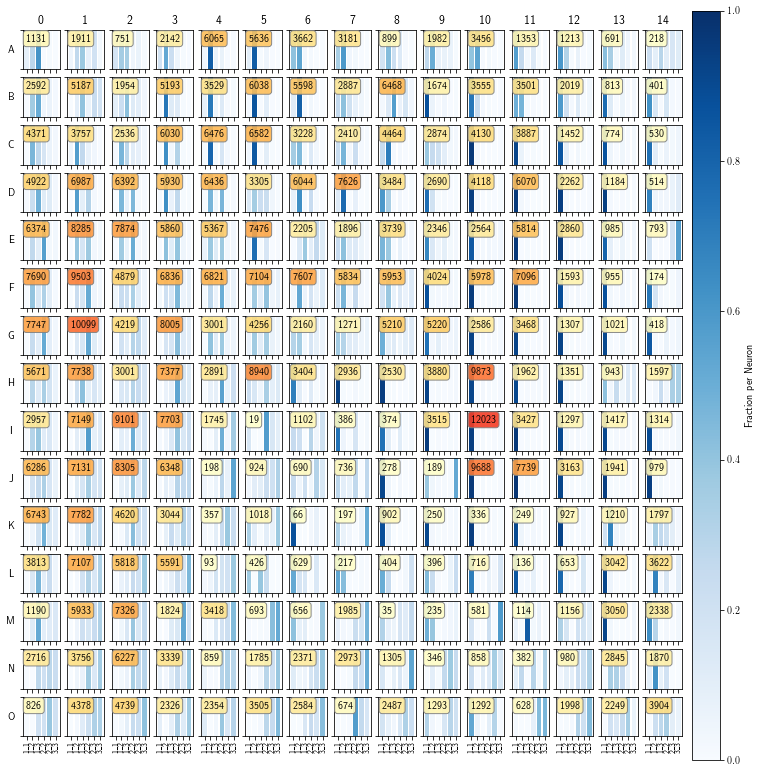

In [10]:
label_plot_heat(book, get_shape(book), color_map='Blues', figsize=(13,13), xtick_rotation=90, count_text=(0.1,0.7), save='Images/Figure_Label_Distribution_Heat.pdf')

In [11]:
def label_plot_heat_bar(book, shape, save=None, xtick_rotation=None, 
                color_map='gnuplot2', title=None, weights=None, figsize=(6,6),
                literal_path=False, count_text=False):
    '''Isolated function to plot the attribute histogram if the data is labelled in 
    nature

    book - dict
        A dictionary whose keys are the location on the heatmap, and values
        are the list of values of sources who most belonged to that grid
    shape - tuple
        The shape of the grid. Should attempt to get this from the keys or
        possible recreate it like in self.attribute_heatmap() 
    save - None or Str
        If None, show the figure on screen. Otherwise save to the path in save
    xtick_rotation - None or float
        Will rotate the xlabel by rotation
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()
    title - None of str
        A simple title strng passed to fig.suptitle()
    weights - None or dict
        If not None, the dict will have keys corresponding to the labels, and contain the total
        set of counts from the Binary file/book object. This will be used to `weigh` the contribution
        per neuron, to instead be a fraction of dataset type of statistic. 
    figsize - tuple of int
        Size of the figure to produce. Passed directly to plt.subplots
    literal_path - bool
        If true, take the path and do not modify it. If False, prepend the project_dir path
    count_label - bool
        If true, put as an anotation the counts of items in that neuron plot
    '''
    # Need access to the Normalise and ColorbarBase objects
    import matplotlib as mpl
    # Step one, get unique items and their counts
    from collections import Counter
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    unique_labels = []
    for k, v in book.items():
#         v = [i for items in v for i in items]    
        unique_labels += v
        
    unique_labels = list(set(unique_labels))
    unique_labels.sort()
    
    max_val = 0
    plt_book = {}
    
    min_length = 1e10
    max_length = 0
    for k, v in book.items():
#         v = [i for items in v for i in items]
        c = Counter(v)

        if len(v) < min_length:
            min_length = len(v)
        elif len(v) > max_length:
            max_length = len(v)
    
        # Guard agaisnt empty most similar neuron
        if len(v) > 0:
            if weights is not None:
                plt_book[k] = { label: c[label] / weights[label] for label in unique_labels }
            else:
                plt_book[k] = { label: c[label] / len(v) for label in unique_labels }
                
            mv = max(plt_book[k].values())
            max_val = mv if mv > max_val else max_val
        else:
            plt_book[k] = None

    if weights is not None:
        cb_label = 'Fraction of Dataset'
        norm = mpl.colors.Normalize(vmin=0, vmax=max_val)
    else:
        cb_label = 'Fraction per Neuron'
        norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap = plt.get_cmap(color_map)
    
    heat_norm = mpl.colors.Normalize(vmin=min_length, vmax= max_length)
    heat_cmap = plt.get_cmap('YlOrRd')
    
    fig, ax = plt.subplots(nrows=shape[0]+1, ncols=shape[1]+1, figsize=figsize)

    # Set empty axis labels for everything
    for a in ax.flatten():
        a.set(xticklabels=[], yticklabels=[])

    for k, v in plt_book.items():
        if v is None:
            continue

        color = cmap(norm(list(v.values())))

        ax[k].bar(np.arange(len(unique_labels)),
                 [1]*len(unique_labels),
                 color=color,
                 align='center',
                 tick_label=unique_labels)

        ax[k].set(ylim=[0,1])

        if k[1] != -1: # disable this for now.
            ax[k].set(yticklabels=[])
        if k[0] != shape[1]:
            ax[k].set(xticklabels=[])
        else:
            if xtick_rotation is not None:
                ax[k].tick_params(axis='x', rotation=xtick_rotation)
                for item in ax[k].get_xticklabels():
                    item.set_fontsize(7.5)
        
        if k[0] == 0:
            ax[k].set(title=k[1])
        
        if k[1] == 0:
            ax[k].set_ylabel(letters[k[0]], rotation=0, va='center')
            
        if count_text:
#             v = [i for items in book[k] for i in items]
            v = book[k]
#             print(len(v))
            color = heat_cmap(heat_norm(len(v)))
            rect = mpl.patches.Rectangle((0.,0.),1,0.15, transform=ax[k].transAxes, 
                                         facecolor=color, edgecolor='black') 
            ax[k].add_patch(rect)
        
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.84, 0.10, 0.02, 0.8])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label=cb_label)

    fig.subplots_adjust(bottom=0.1)
    cax2 = fig.add_axes([0.1,0.043,0.73,0.02])
    cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=heat_cmap, norm=heat_norm, 
                                      orientation='horizontal', label='Counts per Neuron')
    
    if save is None:
        fig.show()
    else:
        fig.savefig(save)

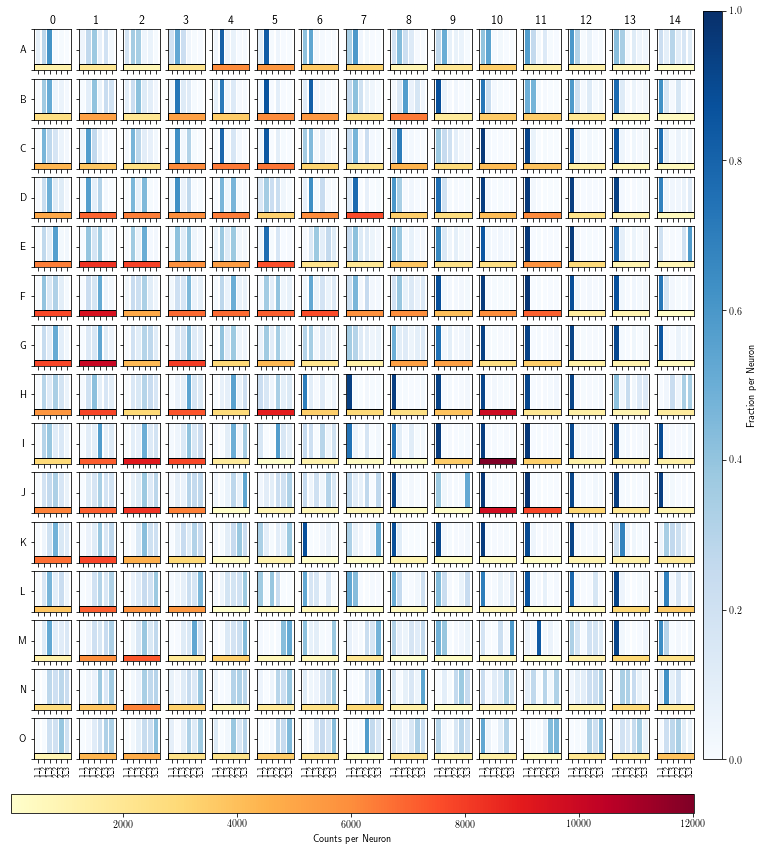

In [12]:
label_plot_heat_bar(book, get_shape(book), color_map='Blues', figsize=(13,13), xtick_rotation=90, count_text=(0.1,0.7),
                    save='Images/Figure_Label_Distribution_HeatBar.pdf')